In [1]:
import seaborn as sns
import metapack as mp
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import display 
from dtcv import get_image # Local package for "downtown computer vision"
import cv2

%matplotlib inline
sns.set_context('notebook')
mp.jupyter.init()
%connect_info

{
  "shell_port": 64662,
  "iopub_port": 64663,
  "stdin_port": 64664,
  "control_port": 64666,
  "hb_port": 64665,
  "ip": "127.0.0.1",
  "key": "6ecf7d88-20d879e9ef48f89ce1b4e6b8",
  "transport": "tcp",
  "signature_scheme": "hmac-sha256",
  "kernel_name": ""
}

Paste the above JSON into a file, and connect with:
    $> jupyter <app> --existing <file>
or, if you are local, you can connect with just:
    $> jupyter <app> --existing kernel-d94d2873-97c9-4d49-b575-6804f22a445a.json
or even just:
    $> jupyter <app> --existing
if this is the most recent Jupyter kernel you have started.


In [2]:
#pkg = mp.jupyter.open_package()
#pkg = mp.jupyter.open_source_package()
pkg = mp.open_package('http://library.metatab.org/sandiegodata.org-downtown_cv-5.zip')

pkg

# San Diego Downtown Homless Computer Vision Package
`sandiegodata.org-downtown_cv-5` Last Update: 2019-09-13T04:52:01

_Files and code for analyzing San Diego downtown homelessness  data with computer vision_


This dataset collects records related to a conversion of 5 years of paper maps
that record positions of homeless sleepers in downtown San Diego. The San Diego
Regional Data Library is [converting these paper maps to a digital
form](http://downtown-homelessness.sandiegodata.org/) with a manual process that
uses an image annotation tool, and theses annotations can be used to train
computer vision algorithms to georeference maps and recognize handwritten marks.

These datasets link to map urls and annotations, for three kinds of annotations:

* Ground Control Points, which identify the map image locations for known intersections, linking image coordinates ( in pixels ) to geographic coordinates.
* Image locations of handwritten marks and the number written in the mark.
* File annotations, for other handwritten notes such as the temperature and presence of rain. 

## More Information:

* [Blog Post](https://www.sandiegodata.org/2019/09/computer-vision-for-greater-good/). For more discussion about the GCP and handwritten marks, and the tasks in volved
in developing computer vision algorithms for these data, see our recent blog
post on the subject.
* [Clustering Notebook](https://nbviewer.jupyter.org/github/sandiegodata-projects/homelessness/blob/master/datasets/sandiegodata.org-downtown_cv/notebooks/Template%20Matching%20Clusters.ipynb). For some examples of using OpenCV to extract and match templates, to georeference maps, see the Templates and Clustering Jupyter Notebook].
* [Extract Marks Notebook](https://nbviewer.jupyter.org/github/sandiegodata-projects/homelessness/blob/master/datasets/sandiegodata.org-downtown_cv/notebooks/Extract%20Marks.ipynb). For examples of extracting ( but not recognizing ) handwritten marks, see this notebook. 


## Developer notes

After anotation JSON files are copied into S#, the list of S# urls must be
updated. To refresh the list of urls run

    $  bin/update_s3.sh <s3-profile>


 

## Contacts

* **Wrangler** [Eric Busboom](mailto:eric@civicknowledge.com), [Civic Knowledge](http://civicknowledge.com)

## Resources

* ** [gcp](data/gcp.csv)**. Ground control points
* ** [intersection_regions](data/intersection_regions.csv)**. Polygon transformations for each the intersections of each map
* ** [intersections](data/intersections.csv)**. List of intersections.
* ** [file_annotations](data/file_annotations.csv)**. File annotations on count files
* ** [counts](data/counts.csv)**. Annotation position, types and counts of handwritten marks

In [3]:
display(pkg.resource('counts'))
counts = pkg.resource('counts').dataframe()

Header,Type,Description
image_url,string,Map image URL
cx,integer,"X value of the center of the circle region, in pixels"
cy,integer,Y value of the center of the circle region in pixels
r,integer,"Radius of the circle region, in pixels"
type,string,"Type of sleeper: Individual, Vehicle or Structure"
count,string,Count of sleepers


In [4]:
# This may take a few minutes; it will download about 330 images and save them to the /tmp directory
counts['image'] = counts.image_url.apply(get_image)

counts['count'] = pd.to_numeric(counts['count'])

In [5]:
len(counts)

5598

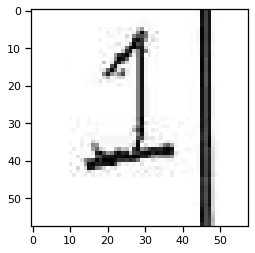

In [6]:
def crop(row):
    """Crop the handwritten mark, and hopefully the shape around it, from the image"""
    x, y, r = row.cx, row.cy, row.r
    
    r = int(r*1.0)
   
    return row.image[y-r:y+r, x-r:x+r ]

plt.imshow(crop(counts.iloc[60]))

4153


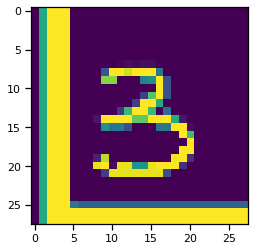

In [7]:
numbers = []

def invert(img):
    # Convert the img to grayscale 
    gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY) 
    r = cv2.resize(gray, (28,28))
    r = np.max(r)-r
    #_, tr = cv2.threshold (r, 70, 255, cv2.THRESH_BINARY_INV);
    return r

for  name, row in  counts.iterrows():
    # Only get digits from 1 to 9
    if row['count'] is not None and not np.isnan(row['count']) and row['count'] < 10 :
        numbers.append((row['count'], invert(crop(row))))
    
print(len(numbers))
plt.imshow(numbers[10][1])

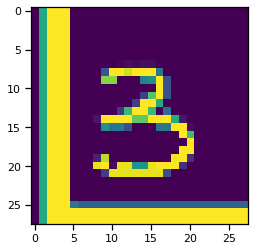

In [8]:
plt.imshow((numbers[10][1][:,:,np.newaxis]))

In [9]:
# baseline cnn model for mnist
from numpy import mean
from numpy import std
from matplotlib import pyplot as plt
from sklearn.model_selection import KFold
from tensorflow.keras.datasets import mnist
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Flatten
from tensorflow.keras.optimizers import SGD 
from keras.utils.data_utils import get_file



# plot diagnostic learning curves
def summarize_diagnostics(histories):
    for i in range(len(histories)):
        # plot loss
        plt.subplot(2, 1, 1)
        plt.title('Cross Entropy Loss')
        plt.plot(histories[i].history['loss'], color='blue', label='train')
        plt.plot(histories[i].history['val_loss'], color='orange', label='test')
        # plot accuracy
        plt.subplot(2, 1, 2)
        plt.title('Classification Accuracy')
        plt.plot(histories[i].history['accuracy'], color='blue', label='train')
        plt.plot(histories[i].history['val_accuracy'], color='orange', label='test')
    plt.show()
 
# summarize model performance
def summarize_performance(scores):
    # print summary
    print('Accuracy: mean=%.3f std=%.3f, n=%d' % (mean(scores)*100, std(scores)*100, len(scores)))
    # box and whisker plots of results
    plt.boxplot(scores)
    plt.show()
 

origin_folder = 'https://storage.googleapis.com/tensorflow/tf-keras-datasets/'
path = get_file(
  'mnist.npz',
  origin=origin_folder + 'mnist.npz',
  file_hash=
  '731c5ac602752760c8e48fbffcf8c3b850d9dc2a2aedcf2cc48468fc17b673d1')


with np.load(path, allow_pickle=True) as f:  
    x_train, y_train = f['x_train'], f['y_train']
    x_test, y_test = f['x_test'], f['y_test']

X = np.concatenate([x_train, x_test], axis=0)
y = np.concatenate([y_train, y_test], axis=0)
 
#X = x_train
#y = y_train
    
X = X.reshape((X.shape[0], 28, 28, 1))
X = X.astype('float32') / np.max(X)


y = to_categorical(y)


(array([0., 0., 0., 1., 0., 0., 0., 0., 0., 0.], dtype=float32),
 <matplotlib.image.AxesImage at 0x1984bc370>)

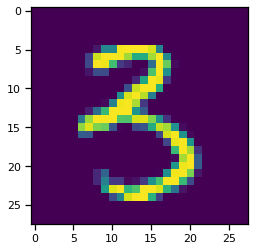

In [10]:
y[65000], plt.imshow(X[65000])

# MNIST Model Example

2022-04-15 15:15:44.669852: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Epoch 1/3
1750/1750 [==============================] - 14s 8ms/step - loss: 0.1758 - accuracy: 0.9459 - val_loss: 0.0930 - val_accuracy: 0.9699
Epoch 2/3
1750/1750 [==============================] - 14s 8ms/step - loss: 0.0596 - accuracy: 0.9819 - val_loss: 0.0728 - val_accuracy: 0.9791
Epoch 3/3
438/438 [==============================] - 1s 2ms/step - loss: 0.0551 - accuracy: 0.9833
> 98.329
Epoch 1/3
1750/1750 [==============================] - 13s 8ms/step - loss: 0.0338 - accuracy: 0.9898 - val_loss: 0.0268 - val_accuracy: 0.9923
Epoch 2/3
1750/1750 [==============================] - 14s 8ms/step - loss: 0.0216 - accuracy: 0.9934 - val_loss: 0.0303 - val_accuracy: 0.9900
Epoch 3/3
438/438 [==============================] - 1s 3ms/step - loss: 0.0267 - accuracy: 0.9914
> 99.143
Epoch 1/3
1750/1750 [==============================] - 15s 8ms/step - loss: 0.0165 - accuracy: 0.9951 - val_loss: 0.0117 - val_accuracy: 0.9969
Epoch 2/3
1750/1750 [==============================] - 14s 8ms/s

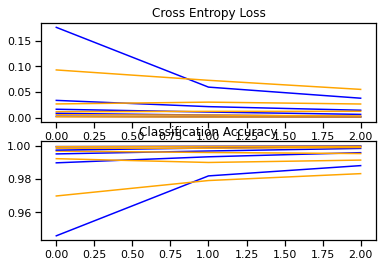

Accuracy: mean=99.376 std=0.601, n=5


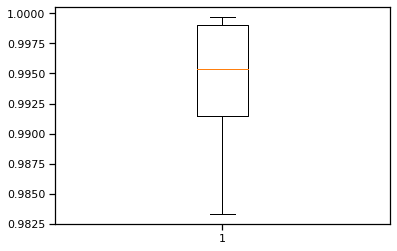

In [11]:

# define cnn model
def define_model():
    model = Sequential()
    model.add(Conv2D(32, (3, 3), activation='relu', 
                     kernel_initializer='he_uniform', input_shape=(28, 28, 1)))
    model.add(MaxPooling2D((2, 2)))
    model.add(Flatten())
    model.add(Dense(100, activation='relu', kernel_initializer='he_uniform'))
    model.add(Dense(10, activation='softmax'))
    # compile model
    opt = SGD(learning_rate=0.01, momentum=0.9)
    model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])
    return model
 
model = define_model()

scores, histories = list(), list()
# prepare cross validation
kfold = KFold(5, shuffle=True, random_state=1)
# enumerate splits
for train_ix, test_ix in kfold.split(X):
    # define model
    
    # select rows for train and test
    trainX, trainY, testX, testY = X[train_ix], y[train_ix], X[test_ix], y[test_ix]
    # fit model
    history = model.fit(trainX, trainY, epochs=3, batch_size=32, 
                        validation_data=(testX, testY), verbose=True)
    
    # evaluate model
    _, acc = model.evaluate(testX, testY, verbose=True)
    print('> %.3f' % (acc * 100.0))
    # stores scores
    scores.append(acc)
    histories.append(history)

# learning curves
summarize_diagnostics(histories)
# summarize estimated performance
summarize_performance(scores)

In [12]:
model.evaluate(testX, testY, verbose=True)

438/438 [==============================] - 1s 3ms/step - loss: 0.0014 - accuracy: 0.9997


[0.0014464037958532572, 0.9997143149375916]

(0, 0, <matplotlib.image.AxesImage at 0x198fc16d0>)

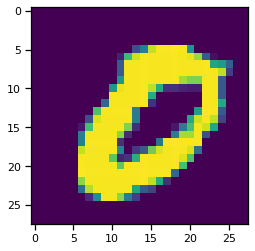

In [13]:
idx = 62376
am = np.argmax(model.predict(X[[idx]]))
am, np.argmax(y[idx]), plt.imshow(X[idx])

# Predict using homelessness digits

(3, 3, <matplotlib.image.AxesImage at 0x199058e20>)

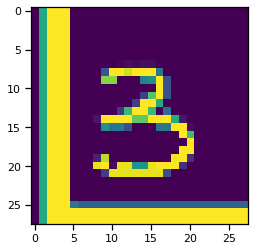

In [14]:
Xhm = np.array([e[1][:,:,np.newaxis] for e in numbers])
yhm = to_categorical(np.array([e[0] for e in numbers]))

idx = 10

am = np.argmax(model.predict(Xhm[[idx]]))
am, np.argmax(yhm[idx]), plt.imshow(Xhm[idx])


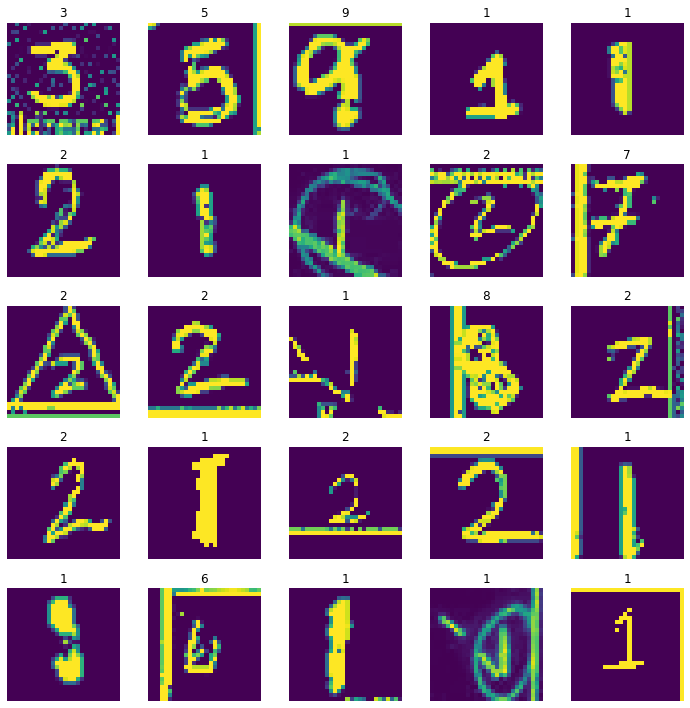

In [15]:
idxes = np.random.choice(np.arange(len(Xhm)), size=25)

fig, axes = plt.subplots(5,5, figsize=(10,10))
axes = np.ravel(axes)

for ax, idx in zip(axes, idxes):
    ax.set_axis_off()
    ax.imshow(Xhm[idx])
    ax.set_title(np.argmax(yhm[idx]))

plt.tight_layout()

In [16]:
model.evaluate(Xhm, yhm, verbose=True)

130/130 [==============================] - 0s 3ms/step - loss: 2048.8259 - accuracy: 0.3829


[2048.825927734375, 0.38285577297210693]

# Retrain with homelessness digits

In [17]:
len(Xhm)

4153

Epoch 1/5
130/130 [==============================] - 2s 10ms/step - loss: 99.6155 - accuracy: 0.2174 - val_loss: 2.1652 - val_accuracy: 0.2295
Epoch 2/5
130/130 [==============================] - 1s 9ms/step - loss: 2.1608 - accuracy: 0.2244 - val_loss: 2.1631 - val_accuracy: 0.2295
Epoch 3/5
130/130 [==============================] - 1s 10ms/step - loss: 2.1574 - accuracy: 0.2244 - val_loss: 2.1657 - val_accuracy: 0.2295
Epoch 4/5
130/130 [==============================] - 1s 11ms/step - loss: 2.1600 - accuracy: 0.2244 - val_loss: 2.1639 - val_accuracy: 0.2295
Epoch 5/5
130/130 [==============================] - 0s 2ms/step - loss: 2.1631 - accuracy: 0.2295
> 22.947
Epoch 1/5
130/130 [==============================] - 1s 9ms/step - loss: 2.1599 - accuracy: 0.2280 - val_loss: 2.1598 - val_accuracy: 0.2244
Epoch 2/5
130/130 [==============================] - 1s 10ms/step - loss: 2.1580 - accuracy: 0.2295 - val_loss: 2.1603 - val_accuracy: 0.2244
Epoch 3/5
130/130 [======================

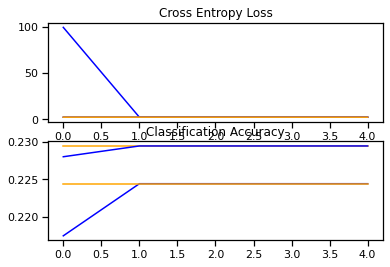

Accuracy: mean=22.694 std=0.253, n=2


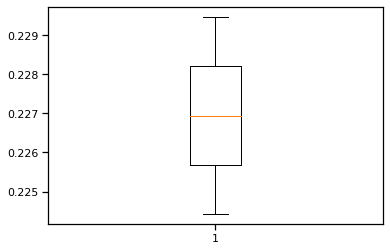

In [18]:
# Make half of the dataset from MNIST
idxes = np.random.choice(np.arange(len(X)), size=len(Xhm) )


X = np.concatenate([Xhm, X[idxes]], axis=0)
y = np.concatenate([yhm, y[idxes]], axis=0)

# define cnn model
def define_model():
    model = Sequential()
    model.add(Conv2D(32, (3, 3), activation='relu', 
                     kernel_initializer='he_uniform', input_shape=(28, 28, 1)))
    model.add(MaxPooling2D((2, 2)))
    model.add(Flatten())
    model.add(Dense(100, activation='relu', kernel_initializer='he_uniform'))
    model.add(Dense(10, activation='softmax'))
    # compile model
    opt = SGD(learning_rate=0.01, momentum=0.9)
    model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])
    return model
 
model = define_model()

scores, histories = list(), list()
# prepare cross validation
kfold = KFold(2, shuffle=True, random_state=1)
# enumerate splits
for train_ix, test_ix in kfold.split(X):
    # define model
    
    # select rows for train and test
    trainX, trainY, testX, testY = X[train_ix], y[train_ix], X[test_ix], y[test_ix]
    # fit model
    history = model.fit(trainX, trainY, epochs=5, batch_size=32, 
                        validation_data=(testX, testY), verbose=True)
    
    # evaluate model
    _, acc = model.evaluate(testX, testY, verbose=True)
    print('> %.3f' % (acc * 100.0))
    # stores scores
    scores.append(acc)
    histories.append(history)

# learning curves
summarize_diagnostics(histories)
# summarize estimated performance
summarize_performance(scores)